## Using Colab GPU for Training


In [1]:
!rm -rf NLP_Colab
!git clone https://github.com/sumkh/NLP_Colab.git

Cloning into 'NLP_Colab'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 93 (delta 52), reused 38 (delta 16), pack-reused 0
Unpacking objects: 100% (93/93), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
!pip install transformers -q

# Training and Fine-Tuning BERT

## Loading the Training and Validation Data

In [6]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("NLP_Colab/Multi3.csv")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 5 random rows from the data.
df.sample(5)

Number of training sentences: 6,697



,mydata,Aspects,Sentiment,Emotion,Aspect,sales,earnings,op_costs,products_services,organic_expansion,acquisitions,competition,op_risks,debt,not_applicable,NIL,label_f,Slabel_f,Elabel_f
4859,We are building on a solid foundation that is ...,"sales,earnings",Positive,Confident,earnings,1,1,0,0,0,0,0,0,0,0,0,1,2,0
5560,So let me start,not_applicable,Neutral,NIL,not_applicable,0,0,0,0,0,0,0,0,0,1,0,9,1,2
1200,Good afternoon,not_applicable,Neutral,NIL,not_applicable,0,0,0,0,0,0,0,0,0,1,0,9,1,2
6187,The idea clearly is to capture new payment flows,not_applicable,Neutral,NIL,not_applicable,0,0,0,0,0,0,0,0,0,1,0,9,1,2
4206,"And I think when that happens, I think some of...","products_services,acquisitions",Neutral,Uncertain,acquisitions,0,0,0,1,0,1,0,0,0,0,0,5,1,3


## BERT Tokenizer

In [7]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...




Let's extract the sentences and labels of our training set as numpy ndarrays.

In [8]:
# Categories of Aspects
label_list = ["sales","earnings","op_costs","products_services","organic_expansion","acquisitions","competition","op_risks","debt","not_applicable","NIL"]
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}
num_labels = len(label_list) # 11

# Categories of Sentiment
Slabel_list = ["Negative","Neutral","Positive",] # Follow order in Slabel_f
Slabel2id = {label: i for i, label in enumerate(Slabel_list)}
Sid2label = {i: label for i, label in enumerate(Slabel_list)}
s_num_labels = len(Slabel_list) # 3

# Categories of Emotion
Elabel_list = ["Confident","Dodgy","NIL","Uncertain"] # Follow order in Elabel_f
Elabel2id = {label: i for i, label in enumerate(Elabel_list)}
Eid2label = {i: label for i, label in enumerate(Elabel_list)}
e_num_labels = len(Elabel_list) # 4

id2label

{0: 'sales',
 1: 'earnings',
 2: 'op_costs',
 3: 'products_services',
 4: 'organic_expansion',
 5: 'acquisitions',
 6: 'competition',
 7: 'op_risks',
 8: 'debt',
 9: 'not_applicable',
 10: 'NIL'}

In [9]:
Sid2label

{0: 'Negative', 1: 'Neutral', 2: 'Positive'}

In [10]:
Eid2label

{0: 'Confident', 1: 'Dodgy', 2: 'NIL', 3: 'Uncertain'}

In [0]:
# Set labels for Aspect
#label_f = df[["sales","earnings","op_costs","products_services","organic_expansion","acquisitions","competition","op_risks","debt","not_applicable","NIL"]]
#label_f = label_f.values.tolist()
#print(label_list)
#print("Number of Labels: " + str(num_labels))
#label_f[0:3]

In [12]:
# Set labels for Aspect
label_f = df[["label_f"]]
label_f = label_f.values.tolist()

# Set labels for Sentiment
s_label_f = df[["Slabel_f"]]
s_label_f = s_label_f.values.tolist()

# Set labels for Emotion
e_label_f = df[["Elabel_f"]]
e_label_f = e_label_f.values.tolist()

# Convert text to numpy arrays
text = df.iloc[:,0]
text = text.values.tolist()
text[0:3]

['Yeah',
 'One is more for the data center',
 'Premiere Pro is the worlds leading video production solution, and continues to grow its footprint across every video segment']

In [14]:
import numpy as np
import argparse
import collections
import logging
import json
import re
import math

import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from transformers import BertTokenizer
from transformers import BertModel

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

class InputExample(object):

    def __init__(self, unique_id, text_a, text_b, labels, s_labels, e_labels):
        self.unique_id = unique_id
        self.text_a = text_a
        self.text_b = text_b
        self.labels = labels
        self.s_labels = s_labels
        self.e_labels = e_labels

# Get the lists of sentences and their labels.
input_file = zip(text, label_f, s_label_f, e_label_f)

corpus = []
unique_id = 0
for txt, lab_f, s_lab_f, e_lab_f in input_file:
  line = txt.strip()
  text_a = None
  text_b = None
  m = re.match(r"^(.*) \|\|\| (.*)$", line)
  if m is None:
    text_a = line
  else:
    text_a = m.group(1)
    text_b = m.group(2)
  
  #label = [np.float(x) for x in lab_f]
  
  corpus.append(InputExample(unique_id=unique_id, text_a=text_a, text_b=text_b, 
                             labels = lab_f, s_labels = s_lab_f, e_labels = e_lab_f))
  unique_id += 1

MAX_LEN = int(math.ceil(max([len(keys.split()) for keys in text])/10)*10)
print('Max sentence length: ' + str(MAX_LEN))

Max sentence length: 160


In [15]:
# Set the maximum sequence length.
# In the original paper, the authors used a length of 512.
seq_length = MAX_LEN 
# type=int
# The maximum total input sequence length after WordPiece tokenization. 
# Sequences longer than this will be truncated, and sequences shorter than this will be padded.

def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, unique_id, labels, s_labels, e_labels, tokens, input_ids, input_mask, input_type_ids):
        self.unique_id = unique_id
        self.labels = labels
        self.s_labels = s_labels
        self.e_labels = e_labels
        self.tokens = tokens
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.input_type_ids = input_type_ids

# Reference: corpus.(unique_id, text_a, text_b, labels, s_labels, e_labels)
features = []
for (txt_index, sent_pair) in enumerate(corpus):
    tokens_a = tokenizer.tokenize(sent_pair.text_a)

    tokens_b = None
    if sent_pair.text_b:
        tokens_b = tokenizer.tokenize(sent_pair.text_b)

    if tokens_b:
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, seq_length - 3)
    else:
        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens_a) > seq_length - 2:
            tokens_a = tokens_a[0:(seq_length - 2)]

    tokens = []
    input_type_ids = []
    tokens.append("[CLS]")
    input_type_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        input_type_ids.append(0)
    tokens.append("[SEP]")
    input_type_ids.append(0)

    if tokens_b:
        for token in tokens_b:
            tokens.append(token)
            input_type_ids.append(1)
        tokens.append("[SEP]")
        input_type_ids.append(1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < seq_length:
        input_ids.append(0)
        input_mask.append(0)
        input_type_ids.append(0)

    assert len(input_ids) == seq_length
    assert len(input_mask) == seq_length
    assert len(input_type_ids) == seq_length

    if txt_index < 5:
        logger.info("******")
        logger.info("unique_id: %s" % (sent_pair.unique_id))
        logger.info("Aspect labels: %s" % (sent_pair.labels))
        logger.info("Sentiment labels: %s" % (sent_pair.s_labels))
        logger.info("Emotion labels: %s" % (sent_pair.e_labels))
        logger.info("tokens: %s" % " ".join([str(x) for x in tokens]))
        logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
        logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
        logger.info(
            "input_type_ids: %s" % " ".join([str(x) for x in input_type_ids]))
        
    features.append(InputFeatures(
                unique_id=sent_pair.unique_id,
                labels=sent_pair.labels,
                s_labels=sent_pair.s_labels,
                e_labels=sent_pair.e_labels,
                tokens=tokens,
                input_ids=input_ids,
                input_mask=input_mask,
                input_type_ids=input_type_ids))
    

03/29/2020 07:07:12 - INFO - __main__ -   ******
03/29/2020 07:07:12 - INFO - __main__ -   unique_id: 0
03/29/2020 07:07:12 - INFO - __main__ -   Aspect labels: [9]
03/29/2020 07:07:12 - INFO - __main__ -   Sentiment labels: [1]
03/29/2020 07:07:12 - INFO - __main__ -   Emotion labels: [2]
03/29/2020 07:07:12 - INFO - __main__ -   tokens: [CLS] yeah [SEP]
03/29/2020 07:07:12 - INFO - __main__ -   input_ids: 101 3398 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
03/29/2020 07:07:12 - INFO - __main__ -   input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Divide up our training set to use 90% for training and 10% for validation.

In [0]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 80% for training and 20% for validation.
#t_features, v_features = train_test_split(features, random_state=123, test_size=0.2)

t_features, v_features = train_test_split(features, random_state=123, test_size=0.2, 
                                          shuffle = True, stratify = [f.s_labels for f in features]) # stratify by Sentiment labels


## Converting to PyTorch Data Types

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32. 
# For Colab, recommend batch size of 8

batch_size = 8
local_rank = -1 
#local_rank for distributed training on gpus

# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
unique_id_to_feature = {}
for feature in t_features:
    unique_id_to_feature[feature.unique_id] = feature

#if local_rank != -1:
#    model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[local_rank], output_device=local_rank)
#elif n_gpu > 1:
#    model = torch.nn.DataParallel(model)


# Convert to tensors, need "input_ids & its index", "input_mask" and "input_label"
# For Training set
t_input_ids = torch.tensor([f.input_ids for f in t_features], dtype=torch.long) # Token ids for every sentences in individual list
t_input_ids_index = torch.arange(t_input_ids.size(0), dtype=torch.long) # Index for each sentences in one list
t_input_mask = torch.tensor([f.input_mask for f in t_features], dtype=torch.long)

# Training and Labels for each task
t_input_label = torch.tensor([f.labels for f in t_features], dtype=torch.long)
t_input_s_label = torch.tensor([f.s_labels for f in t_features], dtype=torch.long)
t_input_e_label = torch.tensor([f.e_labels for f in t_features], dtype=torch.long)

train_data = TensorDataset(t_input_ids, t_input_mask, 
                           t_input_label, t_input_s_label, t_input_e_label, 
                           t_input_ids_index)

# Create the DataLoader for our training set.
if local_rank == -1:
    train_sampler = SequentialSampler(train_data)
else:
    train_sampler = DistributedSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) # No of item in dataloader = Total sample / Batch_size


# For Validation set
v_input_ids = torch.tensor([f.input_ids for f in v_features], dtype=torch.long) # Token ids for every sentences in individual list
v_input_ids_index = torch.arange(v_input_ids.size(0), dtype=torch.long) # Index for each sentences in one list
v_input_mask = torch.tensor([f.input_mask for f in v_features], dtype=torch.long)

# Validation and Labels for each task
v_input_label = torch.tensor([f.labels for f in v_features], dtype=torch.long)
v_input_s_label = torch.tensor([f.s_labels for f in v_features], dtype=torch.long)
v_input_e_label = torch.tensor([f.e_labels for f in v_features], dtype=torch.long)

validation_data = TensorDataset(v_input_ids, v_input_mask, 
                                v_input_label, v_input_s_label, v_input_e_label,
                                v_input_ids_index)

# Create the DataLoader for our validation set.
if local_rank == -1:
    validation_sampler = SequentialSampler(validation_data)
else:
    validation_sampler = DistributedSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size) # No of item in dataloader = Total sample / Batch_size


## Loading the Models

In [76]:
import torch.nn as nn
from torch.nn import CrossEntropyLoss

from transformers.modeling_bert import BertPreTrainedModel, BertModel
from transformers import BertConfig, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 11)
s_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 3)
e_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 4)

# Tell pytorch to run this model on the GPU.
model.to(device)
s_model.to(device)
e_model.to(device)

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr =  2e-5, # args.learning_rate - default is 1e-3 (5e-5, 3e-5, 2e-5)
                  eps = 1e-8) # args.adam_epsilon  - default is 1e-6

s_optimizer = AdamW(s_model.parameters(), lr =  2e-5, eps = 1e-8)
e_optimizer = AdamW(e_model.parameters(), lr =  2e-5, eps = 1e-8)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
s_scheduler = get_linear_schedule_with_warmup(s_optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
e_scheduler = get_linear_schedule_with_warmup(e_optimizer, num_warmup_steps = 0, num_training_steps = total_steps)


03/29/2020 10:11:29 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.8f56353af4a709bf5ff0fbc915d8f5b42bfff892cbb6ac98c3c45f481a03c685
03/29/2020 10:11:29 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "_num_labels": 11,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10"
  },
  "init

## Training Loop

Define a helper function for calculating accuracy.

In [0]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Reference Compute Softmax function using numpy:
# https://gist.github.com/alceufc/f3fd0cd7d9efb120195c
def np_softmax(x):
    scoreMatExp = np.exp(np.asarray(x))
    return scoreMatExp / scoreMatExp.sum(0)

def flat_accuracy(preds, labels):
    preds = np_softmax(preds)
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


## Validation of BERT Model before Fine-Tuning

In [77]:
# Measure how long the training epoch takes.
t0 = time.time()

# Store the average loss after each epoch so we can plot them.
eval_loss_values = []
s_eval_loss_values = []
e_eval_loss_values = []

model.eval()
s_model.eval()
e_model.eval()
     
eval_loss, eval_accuracy = 0, 0
nb_eval_steps = 0

s_eval_loss, s_eval_accuracy = 0, 0
e_eval_loss, e_eval_accuracy = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
        
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
        
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_s_labels, b_e_labels, b_input_ids_index = batch
        
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():       
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        s_output = s_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        e_output = e_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = output[0]
        s_logits = s_output[0]
        e_logits = e_output[0]
        
        # For Aspects Validation:  
        loss_fct = CrossEntropyLoss()
        tmp_eval_loss = loss_fct(logits.view(-1, 11), b_labels.view(-1))
            
        # For Sentiment and Emotion Validation:  
        s_loss_fct = CrossEntropyLoss()
        tmp_s_eval_loss = s_loss_fct(s_logits.view(-1, 3), b_s_labels.view(-1))
          
        e_loss_fct = CrossEntropyLoss()
        tmp_e_eval_loss = e_loss_fct(e_logits.view(-1, 4), b_e_labels.view(-1))
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        s_logits = s_logits.detach().cpu().numpy()
        s_label_ids = b_s_labels.to('cpu').numpy()

        e_logits = e_logits.detach().cpu().numpy()
        e_label_ids = b_e_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        s_tmp_eval_accuracy = flat_accuracy(s_logits, s_label_ids)
        e_tmp_eval_accuracy = flat_accuracy(e_logits, e_label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        s_eval_accuracy += s_tmp_eval_accuracy
        e_eval_accuracy += e_tmp_eval_accuracy

        
    # Average evaluation loss per batch
    eval_loss += tmp_eval_loss.mean().item()
    s_eval_loss += tmp_s_eval_loss.mean().item()
    e_eval_loss += tmp_e_eval_loss.mean().item()
      
    # Track the number of batches
    nb_eval_steps += 1         

eval_loss = eval_loss / nb_eval_steps # total loss/no. of batches
s_eval_loss = s_eval_loss / nb_eval_steps 
e_eval_loss = e_eval_loss / nb_eval_steps

# Store the loss value for plotting the validation curve.
eval_loss_values.append(avg_eval_loss)
s_eval_loss_values.append(s_eval_loss)
e_eval_loss_values.append(e_eval_loss)

    
print("Aspects Mining:")
print("  Loss:   {0:.2f}".format(eval_loss) + "    Accuracy:   {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Sentiment Classification:")
print("  Loss:   {0:.2f}".format(s_eval_loss) + "    Accuracy:   {0:.2f}".format(s_eval_accuracy/nb_eval_steps))
print("Emotion Classification:")
print("  Loss:   {0:.2f}".format(e_eval_loss) + "    Accuracy:   {0:.2f}".format(e_eval_accuracy/nb_eval_steps))
print("")
print("  Validation took: {:}".format(format_time(time.time() - t0)))


Aspects Mining:
  Loss:   2.47    Accuracy:   0.06
Sentiment Classification:
  Loss:   1.24    Accuracy:   0.44
Emotion Classification:
  Loss:   1.39    Accuracy:   0.20

  Validation took: 0:00:22


## Training the Aspects Classification Model

In [69]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 123

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
loss_values.insert(0, None) # to add a None value at starting of training

# For each epoch...
for epoch_i in range(0, epochs):
  
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Train the Aspect Classification Model
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels (Label for Aspect Mining task)
        #   [3]: s_label (Label for Sentiment Classification task)
        #   [4]: e_label (Label for Emotion Classification task)
        #   [5]: input_ids_index

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_s_labels = batch[3].to(device)
        b_e_labels = batch[4].to(device)

        # Training Aspect Classification Model
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]
        total_loss += loss.mean().item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)        
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("    Average Aspect Model training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # Freeze BERT layers and train classifier after first epoch
    for param in model.bert.parameters():
      param.requires_grad = False


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
     
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels, b_s_labels, b_e_labels, b_input_ids_index = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            
            logits = output[0]
            
            # For Aspect Validation:  
            loss_fct = CrossEntropyLoss()
            tmp_eval_loss = loss_fct(logits.view(-1, 11), b_labels.view(-1))
            
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences.
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy
          
        # Average evaluation loss per batch
        eval_loss += tmp_eval_loss.mean().item()
        
        # Track the number of batches
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps # total loss/no. of batches

    # Store the loss value for plotting the validation curve.
    eval_loss_values.append(eval_loss)

    print("Aspects Mining:")
    print("  Loss:   {0:.2f}".format(eval_loss) + "    Accuracy:   {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("")
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
 
print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    670.    Elapsed: 0:00:07.
  Batch    80  of    670.    Elapsed: 0:00:14.
  Batch   120  of    670.    Elapsed: 0:00:21.
  Batch   160  of    670.    Elapsed: 0:00:28.
  Batch   200  of    670.    Elapsed: 0:00:35.
  Batch   240  of    670.    Elapsed: 0:00:43.
  Batch   280  of    670.    Elapsed: 0:00:50.
  Batch   320  of    670.    Elapsed: 0:00:57.
  Batch   360  of    670.    Elapsed: 0:01:04.
  Batch   400  of    670.    Elapsed: 0:01:11.
  Batch   440  of    670.    Elapsed: 0:01:18.
  Batch   480  of    670.    Elapsed: 0:01:25.
  Batch   520  of    670.    Elapsed: 0:01:32.
  Batch   560  of    670.    Elapsed: 0:01:39.
  Batch   600  of    670.    Elapsed: 0:01:46.
  Batch   640  of    670.    Elapsed: 0:01:53.

    Average Aspect Model training loss: 1.15
  Training epcoh took: 0:01:58

Running Validation...
Aspects Mining:
  Loss:   0.84    Accuracy:   0.68

  Validation took: 0:00:07

======== Epoch 2 / 10 ==

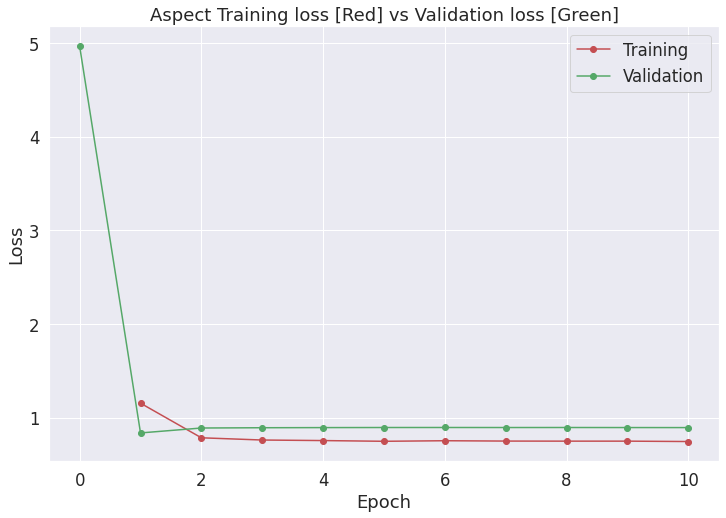

In [70]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,8)

# Plot the learning curve.
plt.plot(loss_values, 'r-o', label="Training") #red
plt.plot(eval_loss_values, 'g-o', label="Validation") #green

# Label the plot.
plt.title("Aspect Training loss [Red] vs Validation loss [Green]")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

plt.show()

#### Saving Fine-Tuned Aspect Model

In [71]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Zip up the folder and copy zip file to Google Drive
!zip -r /content/Aspect_Model.zip /content/model_save/
!cp -r /content/Aspect_Model.zip "./drive/My Drive/Downloads"


03/29/2020 10:03:09 - INFO - transformers.configuration_utils -   Configuration saved in ./model_save/config.json


Saving model to ./model_save/


03/29/2020 10:03:10 - INFO - transformers.modeling_utils -   Model weights saved in ./model_save/pytorch_model.bin


  adding: content/model_save/ (stored 0%)
  adding: content/model_save/config.json (deflated 61%)
  adding: content/model_save/tokenizer_config.json (stored 0%)
  adding: content/model_save/pytorch_model.bin (deflated 7%)
  adding: content/model_save/vocab.txt (deflated 53%)
  adding: content/model_save/special_tokens_map.json (deflated 40%)


## Training the Sentiment Classification Model

In [78]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 123

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
loss_values.insert(0, None) # to add a None value at starting of training

# For each epoch...
for epoch_i in range(0, epochs):
  
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Train the Sentiment Model
    s_model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels (Label for Aspect Mining task)
        #   [3]: s_label (Label for Sentiment Classification task)
        #   [4]: e_label (Label for Emotion Classification task)
        #   [5]: input_ids_index

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_s_labels = batch[3].to(device)
        b_e_labels = batch[4].to(device)

        # Training Aspect Classification Model
        s_model.zero_grad()
        outputs = s_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_s_labels)

        loss = outputs[0]
        total_loss += loss.mean().item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(s_model.parameters(), 1.0)
        s_optimizer.step()
        s_scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)        
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("    Average Sentiment Model training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # Freeze BERT layers and train classifier after first epoch
    for param in s_model.bert.parameters():
      param.requires_grad = False


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    s_model.eval()
     
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels, b_s_labels, b_e_labels, b_input_ids_index = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            output = s_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            
            logits = output[0]
            
            # For Aspect Validation:  
            loss_fct = CrossEntropyLoss()
            tmp_eval_loss = loss_fct(logits.view(-1, 3), b_s_labels.view(-1))
            
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_s_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences.
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy
          
        # Average evaluation loss per batch
        eval_loss += tmp_eval_loss.mean().item()
        
        # Track the number of batches
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps # total loss/no. of batches

    # Store the loss value for plotting the validation curve.
    s_eval_loss_values.append(eval_loss)

    print("Sentiment Classification:")
    print("  Loss:   {0:.2f}".format(eval_loss) + "    Accuracy:   {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("")
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
 
print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    670.    Elapsed: 0:00:07.
  Batch    80  of    670.    Elapsed: 0:00:14.
  Batch   120  of    670.    Elapsed: 0:00:21.
  Batch   160  of    670.    Elapsed: 0:00:28.
  Batch   200  of    670.    Elapsed: 0:00:35.
  Batch   240  of    670.    Elapsed: 0:00:43.
  Batch   280  of    670.    Elapsed: 0:00:50.
  Batch   320  of    670.    Elapsed: 0:00:57.
  Batch   360  of    670.    Elapsed: 0:01:04.
  Batch   400  of    670.    Elapsed: 0:01:11.
  Batch   440  of    670.    Elapsed: 0:01:18.
  Batch   480  of    670.    Elapsed: 0:01:25.
  Batch   520  of    670.    Elapsed: 0:01:32.
  Batch   560  of    670.    Elapsed: 0:01:39.
  Batch   600  of    670.    Elapsed: 0:01:46.
  Batch   640  of    670.    Elapsed: 0:01:53.

    Average Sentiment Model training loss: 0.54
  Training epcoh took: 0:01:59

Running Validation...
Sentiment Classification:
  Loss:   0.42    Accuracy:   0.72

  Validation took: 0:00:07

======== Ep

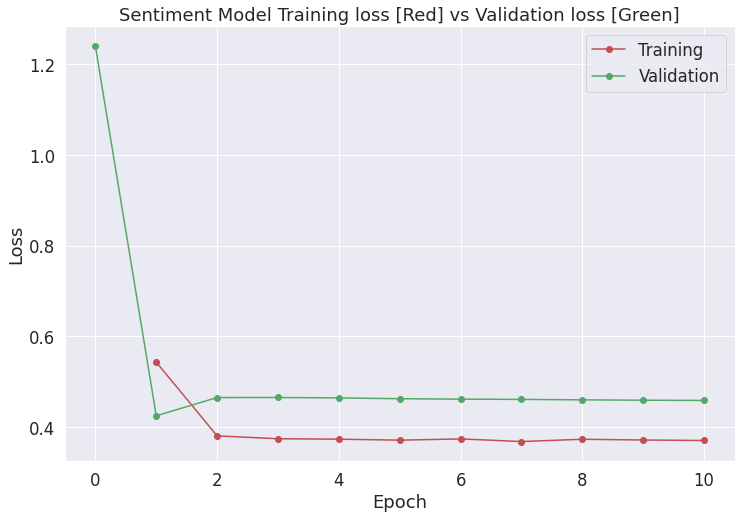

In [79]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,8)

# Plot the learning curve.
plt.plot(loss_values, 'r-o', label="Training") #red
plt.plot(s_eval_loss_values, 'g-o', label="Validation") #green

# Label the plot.
plt.title("Sentiment Model Training loss [Red] vs Validation loss [Green]")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

plt.show()

#### Saving Fine-Tuned Sentiment Model

In [80]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './s_model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = s_model.module if hasattr(s_model, 'module') else s_model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Zip up the folder and copy zip file to Google Drive
!zip -r /content/Sentiment_Model.zip /content/s_model_save/
!cp -r /content/Sentiment_Model.zip "./drive/My Drive/Downloads"


03/29/2020 10:26:38 - INFO - transformers.configuration_utils -   Configuration saved in ./s_model_save/config.json


Saving model to ./s_model_save/


03/29/2020 10:26:40 - INFO - transformers.modeling_utils -   Model weights saved in ./s_model_save/pytorch_model.bin


  adding: content/s_model_save/ (stored 0%)
  adding: content/s_model_save/config.json (deflated 57%)
  adding: content/s_model_save/tokenizer_config.json (stored 0%)
  adding: content/s_model_save/pytorch_model.bin (deflated 7%)
  adding: content/s_model_save/vocab.txt (deflated 53%)
  adding: content/s_model_save/special_tokens_map.json (deflated 40%)


## Training the Emotion Classification Model

In [81]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 123

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
loss_values.insert(0, None) # to add a None value at starting of training

# For each epoch...
for epoch_i in range(0, epochs):
  
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Train the Sentiment Model
    e_model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels (Label for Aspect Mining task)
        #   [3]: s_label (Label for Sentiment Classification task)
        #   [4]: e_label (Label for Emotion Classification task)
        #   [5]: input_ids_index

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_s_labels = batch[3].to(device)
        b_e_labels = batch[4].to(device)

        # Training Aspect Classification Model
        e_model.zero_grad()
        outputs = e_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_e_labels)

        loss = outputs[0]
        total_loss += loss.mean().item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(e_model.parameters(), 1.0)
        e_optimizer.step()
        e_scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)        
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("    Average Sentiment Model training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # Freeze BERT layers and train classifier after first epoch
    for param in e_model.bert.parameters():
      param.requires_grad = False


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    e_model.eval()
     
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels, b_s_labels, b_e_labels, b_input_ids_index = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            output = e_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            
            logits = output[0]
            
            # For Aspect Validation:  
            loss_fct = CrossEntropyLoss()
            tmp_eval_loss = loss_fct(logits.view(-1, 4), b_e_labels.view(-1))
            
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_e_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences.
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy
          
        # Average evaluation loss per batch
        eval_loss += tmp_eval_loss.mean().item()
        
        # Track the number of batches
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps # total loss/no. of batches

    # Store the loss value for plotting the validation curve.
    e_eval_loss_values.append(eval_loss)

    print("Emotion Classification:")
    print("  Loss:   {0:.2f}".format(eval_loss) + "    Accuracy:   {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("")
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
 
print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    670.    Elapsed: 0:00:07.
  Batch    80  of    670.    Elapsed: 0:00:14.
  Batch   120  of    670.    Elapsed: 0:00:21.
  Batch   160  of    670.    Elapsed: 0:00:28.
  Batch   200  of    670.    Elapsed: 0:00:35.
  Batch   240  of    670.    Elapsed: 0:00:42.
  Batch   280  of    670.    Elapsed: 0:00:50.
  Batch   320  of    670.    Elapsed: 0:00:57.
  Batch   360  of    670.    Elapsed: 0:01:04.
  Batch   400  of    670.    Elapsed: 0:01:11.
  Batch   440  of    670.    Elapsed: 0:01:18.
  Batch   480  of    670.    Elapsed: 0:01:25.
  Batch   520  of    670.    Elapsed: 0:01:32.
  Batch   560  of    670.    Elapsed: 0:01:39.
  Batch   600  of    670.    Elapsed: 0:01:46.
  Batch   640  of    670.    Elapsed: 0:01:53.

    Average Sentiment Model training loss: 0.64
  Training epcoh took: 0:01:59

Running Validation...
Emotion Classification:
  Loss:   0.53    Accuracy:   0.65

  Validation took: 0:00:07

======== Epoc

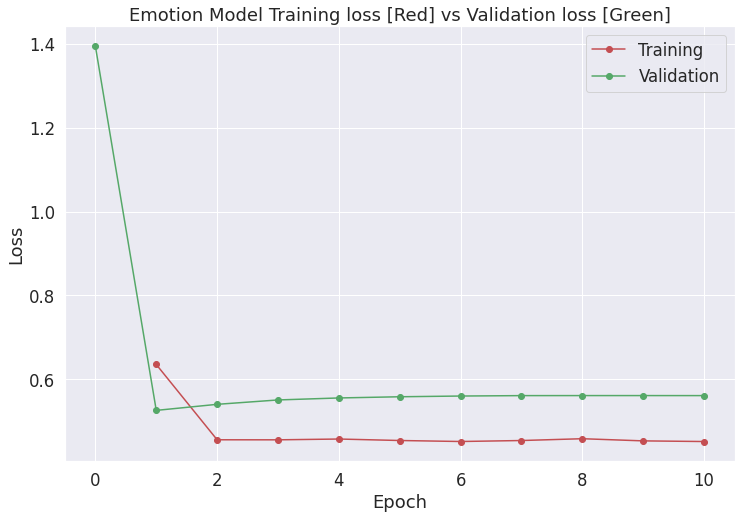

In [82]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,8)

# Plot the learning curve.
plt.plot(loss_values, 'r-o', label="Training") #red
plt.plot(e_eval_loss_values, 'g-o', label="Validation") #green

# Label the plot.
plt.title("Emotion Model Training loss [Red] vs Validation loss [Green]")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

plt.show()

#### Saving Fine-Tuned Emotion Model

In [83]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './e_model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = e_model.module if hasattr(e_model, 'module') else e_model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Zip up the folder and copy zip file to Google Drive
!zip -r /content/Emotion_Model.zip /content/e_model_save/
!cp -r /content/Emotion_Model.zip "./drive/My Drive/Downloads"


03/29/2020 10:46:51 - INFO - transformers.configuration_utils -   Configuration saved in ./e_model_save/config.json


Saving model to ./e_model_save/


03/29/2020 10:46:52 - INFO - transformers.modeling_utils -   Model weights saved in ./e_model_save/pytorch_model.bin


  adding: content/e_model_save/ (stored 0%)
  adding: content/e_model_save/config.json (deflated 57%)
  adding: content/e_model_save/tokenizer_config.json (stored 0%)
  adding: content/e_model_save/pytorch_model.bin (deflated 7%)
  adding: content/e_model_save/vocab.txt (deflated 53%)
  adding: content/e_model_save/special_tokens_map.json (deflated 40%)
